In [110]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from PIL import Image
from skimage import data, io, transform

## Introduction

### SIFT Wafer Map

In [2]:
df = pd.read_pickle("../data/processed/WM811K/train_val_data.pkl.xz")
df

waferMap failureType   
21324  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc  \
30039  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc   
45248  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc   
30370  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc   
27540  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         Loc   
...                                                  ...         ...   
28880  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   Near-full   
29003  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   Near-full   
18124  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25...   Near-full   
55768  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25...   Near-full   
44926  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255...   Near-full   

       failureCode  
21324            4  
30039            4  
45248            4  
30370            4  
27540            4  
...            ...  
28880            5  
29003            5  
18124            5  
55768            5  
44926            5  

[49798 rows x 3 columns]

Index([25325], dtype='int64')


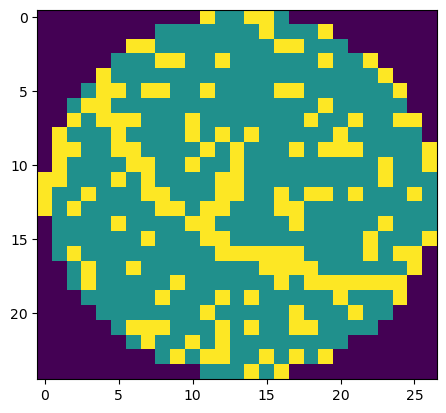

In [44]:
# Grab a random wafer map with a Scratch failureType
scratch_row = df[df["failureType"] == "Scratch"].sample(1)
print(scratch_row.index)

# Grab the wafer map and label
wafer = scratch_row.waferMap.values[0]
plt.imshow(wafer)

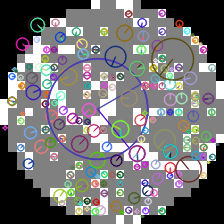

In [59]:
# wafer = df.loc[25325].waferMap
wafer = cv2.resize(wafer, (224, 224), interpolation=cv2.INTER_NEAREST_EXACT)

def draw_sift_keypoints(wafermap):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(wafermap, None)
    img = cv2.drawKeypoints(
        wafermap, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    return img

img = draw_sift_keypoints(wafer)
pil_img = Image.fromarray(img)#.resize((512, 512), Image.NEAREST)
display(pil_img)
pil_img.save("../reports/figures/sift_wafer.png")

## Issues with annotation

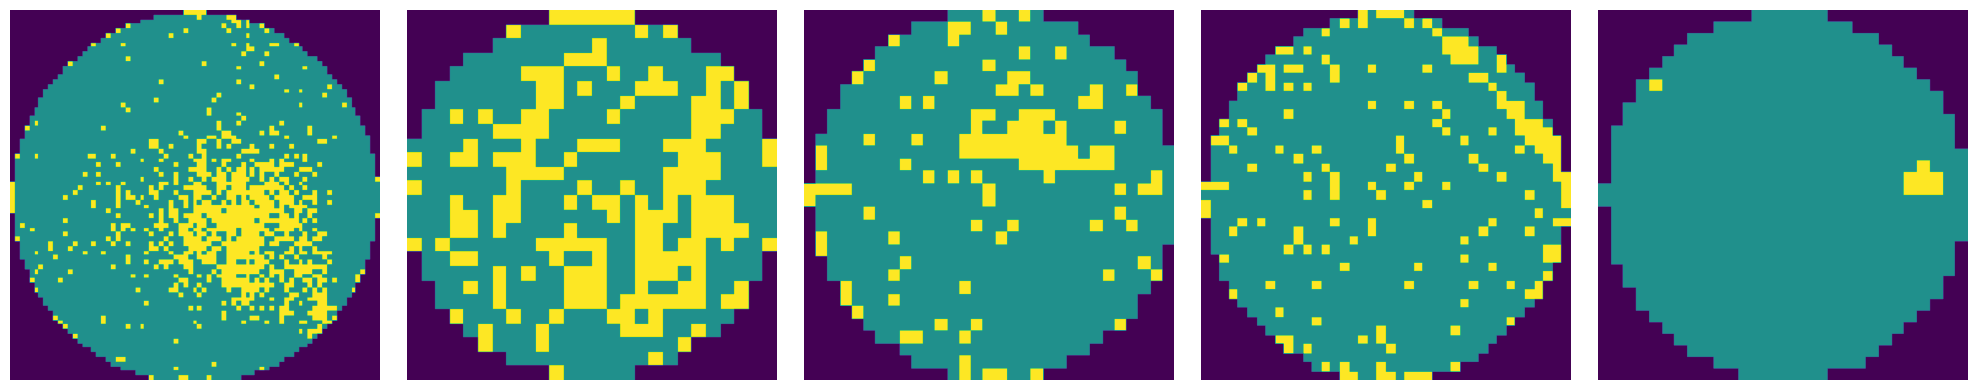

In [80]:
# Sample 5 wafers of the "Loc" failureType. Resize to 224x224 and plot in subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axes):
    wafer = df[df["failureType"] == "Loc"].sample(1).waferMap.values[0]
    wafer = cv2.resize(wafer, (224, 224), interpolation=cv2.INTER_NEAREST_EXACT)
    ax.imshow(wafer)
    # ax.set_title(f"Loc Wafer {i}")
    ax.set_axis_off()
plt.tight_layout()
plt.savefig("../reports/figures/loc_wafers.png", dpi=300)
plt.show()

## Masked Autoencoder: Patchify and Mask

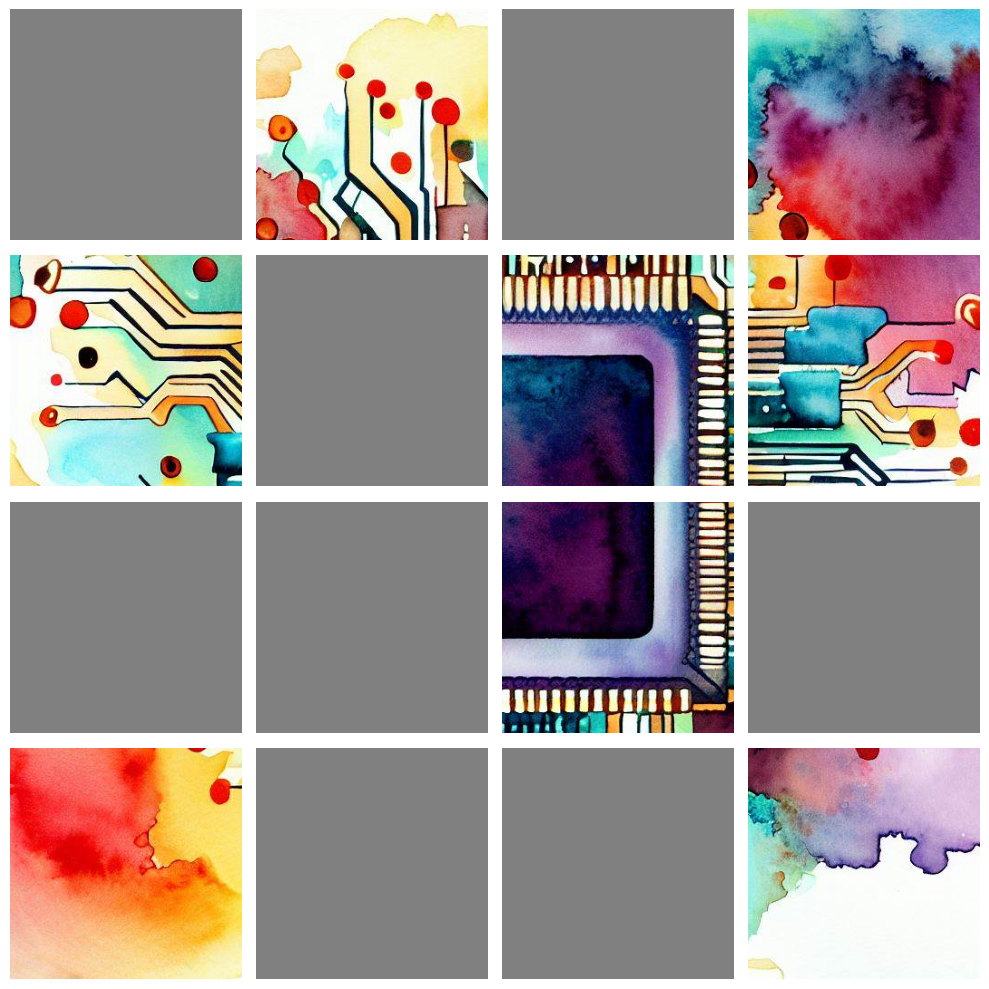

In [48]:
img = io.imread("../reports/figures/watercolor_chip.png")

# Divide the image into N x N patches
N = 4
patches = [
    img[x : x + img.shape[0] // N, y : y + img.shape[1] // N]
    for x in range(0, img.shape[0], img.shape[0] // N)
    for y in range(0, img.shape[1], img.shape[1] // N)
]

# Randomly select M of the patches (do this using indices to avoid issues)
M = 8
idx = np.random.choice(len(patches), M, replace=False)

# For these M patches, replace them all with masked out patches
# masked_patch will just be the same size, but all zeros
patches = [
    patches[i] if i not in idx else np.full_like(patches[i], 128)
    for i in range(len(patches))
]

# Now, plot the patches in subplots
fig, axes = plt.subplots(N, N, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(patches[i])
    ax.set_axis_off()
plt.tight_layout()
plt.savefig(
    "../reports/figures/watercolor_chip_masked.png", dpi=300, bbox_inches="tight"
)
plt.show()

## Masked Siamese Network: Random and Focal Mask

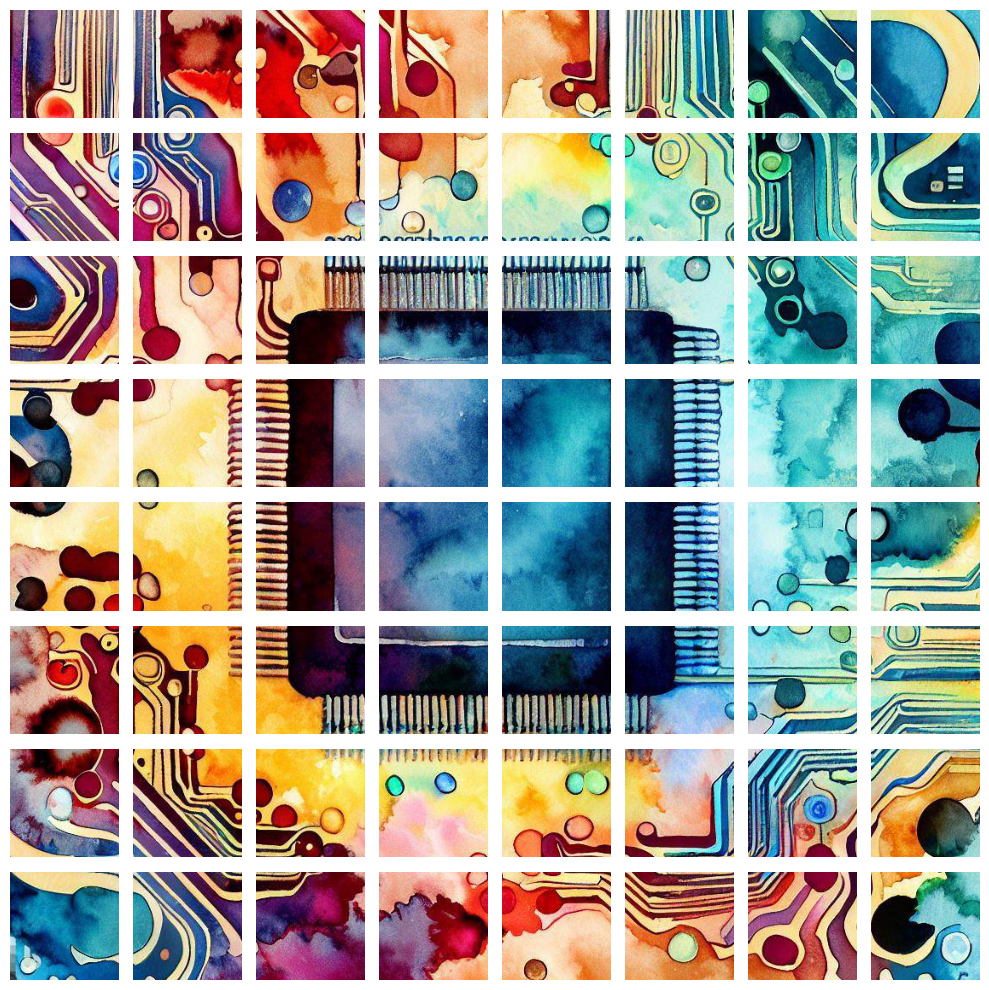

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

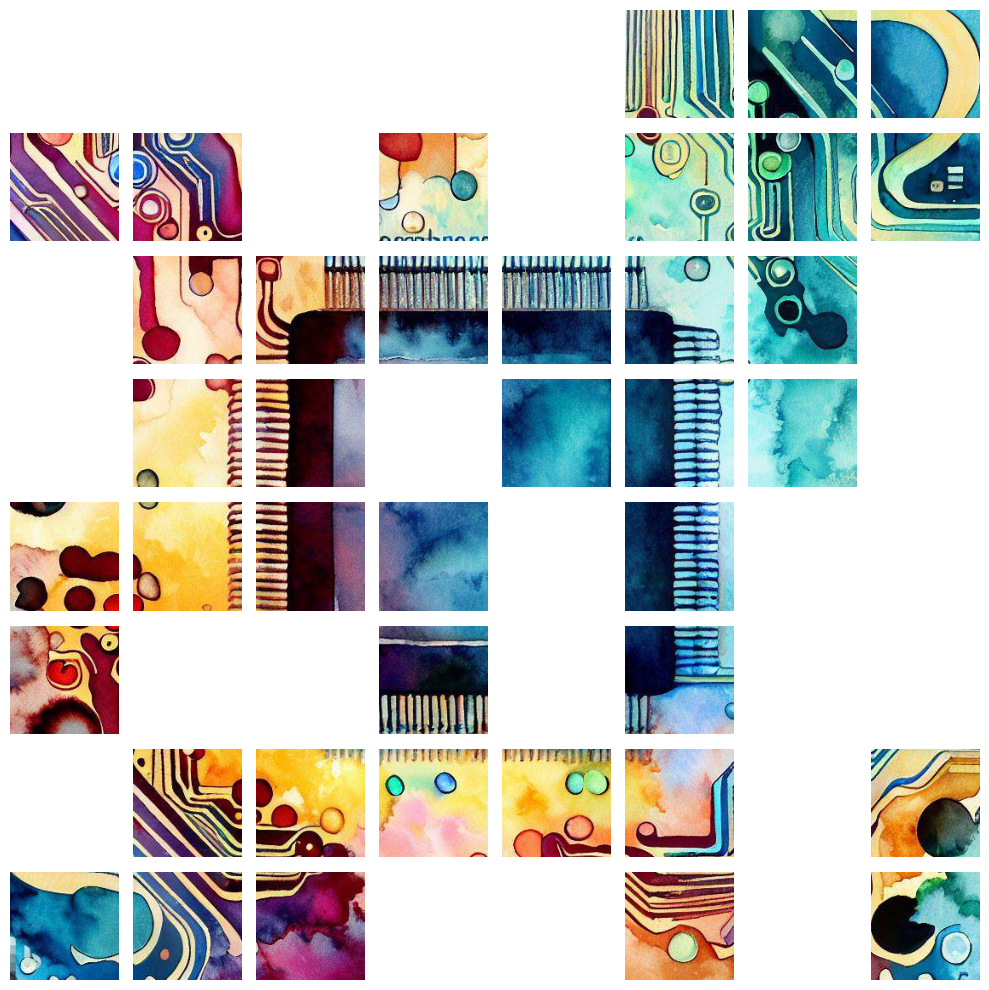

In [65]:
img = io.imread("../reports/figures/watercolor_chip3.jpg")
img = transform.resize(img, (1024, 1024), anti_aliasing=True)

# Divide the image into N x N patches
N = 8
patches = [
    img[x : x + img.shape[0] // N, y : y + img.shape[1] // N]
    for x in range(0, img.shape[0], img.shape[0] // N)
    for y in range(0, img.shape[1], img.shape[1] // N)
]

# Randomly select M of the patches (do this using indices to avoid issues)
M = int(N * N * 0.4)
idx = np.random.choice(len(patches), M, replace=False)

# For these M patches, replace them all with masked out patches
# masked_patch will just be the same size, but all zeros
new_patches = [
    patches[i] if i not in idx else np.full_like(patches[i], 128)
    for i in range(len(patches))
]

# Plot the original patchified image
fig, axes = plt.subplots(N, N, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(patches[i])
    ax.set_axis_off()
plt.tight_layout()
plt.savefig(
    "../reports/figures/patchified.jpg", dpi=300, bbox_inches="tight"
)
plt.show()

# Now, plot the random masked patches
fig, axes = plt.subplots(N, N, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(new_patches[i])
    ax.set_axis_off()
plt.tight_layout()
plt.savefig(
    "../reports/figures/random_mask.jpg", dpi=300, bbox_inches="tight"
)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

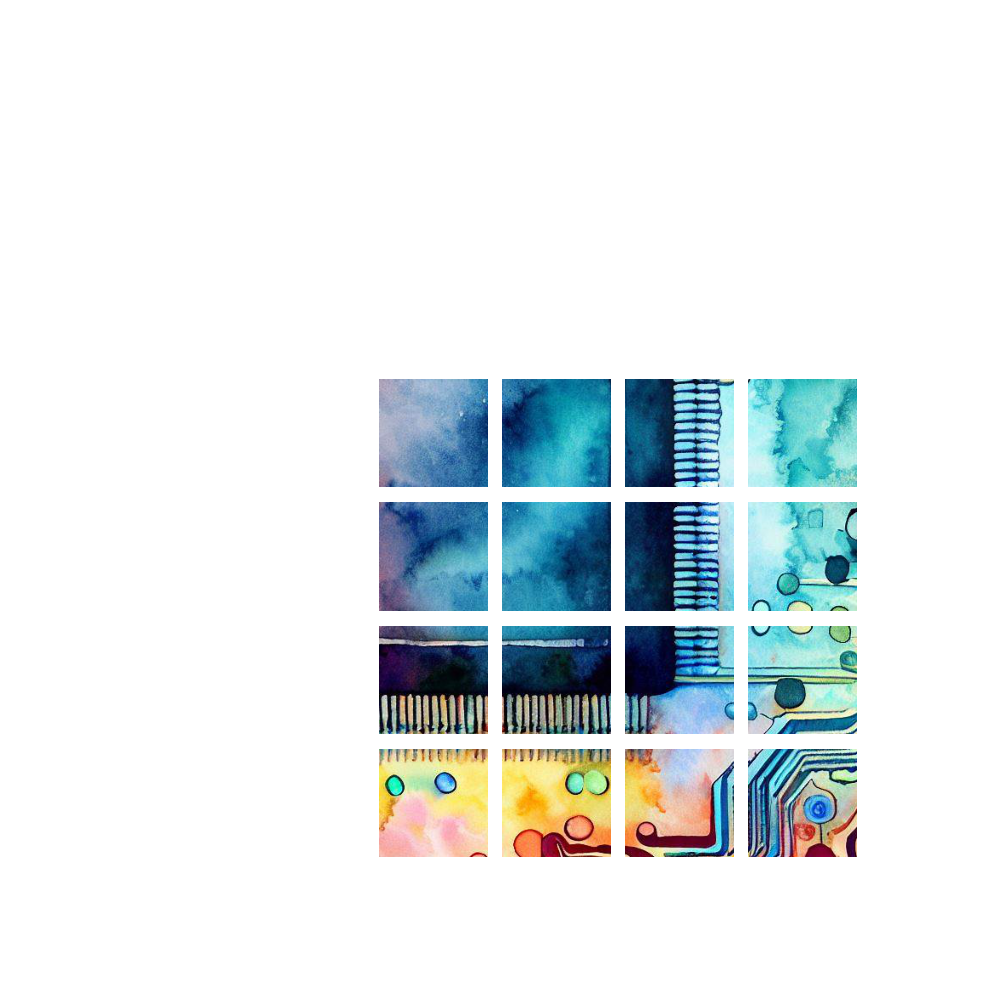

In [59]:
# Divide the image into N x N patches
N = 8
patches = [
    img[x : x + img.shape[0] // N, y : y + img.shape[1] // N]
    for x in range(0, img.shape[0], img.shape[0] // N)
    for y in range(0, img.shape[1], img.shape[1] // N)
]

# Randomly select M of the patches (do this using indices to avoid issues)
M = int(N * N * 0.3)
idx = np.array([np.arange(27,31), np.arange(35,39), np.arange(43,47), np.arange(51, 55)])

# For these M patches, replace them all with masked out patches
# masked_patch will just be the same size, but all zeros
patches = [
    patches[i] if i in idx else np.full_like(patches[i], 128)
    for i in range(len(patches))
]

# Now, plot the patches in subplots
fig, axes = plt.subplots(N, N, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(patches[i])
    ax.set_axis_off()
plt.tight_layout()
plt.savefig(
    "../reports/figures/focal_mask.jpg", dpi=300, bbox_inches="tight"
)
plt.show()

## Class Frequencies

In [11]:
original_data = pd.read_pickle("../data/raw/MIR-WM811K/Python/WM811K.pkl")

In [12]:
# [0, 0] is unhashable in failureType and trainTestLabel --> replace with "unlabeled"
# Use pd.api.types.is_array_like to check if a value is array-like
original_data.loc[original_data.failureType.apply(pd.api.types.is_array_like), "failureType"] = "unlabeled"
original_data.loc[original_data.trainTestLabel.apply(pd.api.types.is_array_like), "trainTestLabel"] = "unlabeled"
original_data

dieSize failureType   lotName trainTestLabel  waferIndex   
0        1683.0        none      lot1       Training         1.0  \
1        1683.0        none      lot1       Training         2.0   
2        1683.0        none      lot1       Training         3.0   
3        1683.0        none      lot1       Training         4.0   
4        1683.0        none      lot1       Training         5.0   
...         ...         ...       ...            ...         ...   
811452    600.0   Edge-Ring  lot47542           Test        23.0   
811453    600.0    Edge-Loc  lot47542           Test        24.0   
811454    600.0   Edge-Ring  lot47542           Test        25.0   
811455    600.0   unlabeled  lot47543      unlabeled         1.0   
811456    600.0   unlabeled  lot47543      unlabeled         2.0   

                                                 waferMap  
0       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
1       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
4       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
...                                                   ...  
811452  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...  
811453  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...  
811454  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...  
811455  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...  
811456  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...  

[811457 rows x 6 columns]

In [13]:
# Capitalize failureType if it is "none"
original_data.loc[original_data.failureType == "none", "failureType"] = "None"
original_data

dieSize failureType   lotName trainTestLabel  waferIndex   
0        1683.0        None      lot1       Training         1.0  \
1        1683.0        None      lot1       Training         2.0   
2        1683.0        None      lot1       Training         3.0   
3        1683.0        None      lot1       Training         4.0   
4        1683.0        None      lot1       Training         5.0   
...         ...         ...       ...            ...         ...   
811452    600.0   Edge-Ring  lot47542           Test        23.0   
811453    600.0    Edge-Loc  lot47542           Test        24.0   
811454    600.0   Edge-Ring  lot47542           Test        25.0   
811455    600.0   unlabeled  lot47543      unlabeled         1.0   
811456    600.0   unlabeled  lot47543      unlabeled         2.0   

                                                 waferMap  
0       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
1       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
4       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
...                                                   ...  
811452  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...  
811453  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...  
811454  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...  
811455  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...  
811456  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...  

[811457 rows x 6 columns]

In [37]:
original_train = original_data[original_data.trainTestLabel == "Training"]
original_test = original_data[original_data.trainTestLabel == "Test"]
new_data = pd.read_pickle("../data/processed/WM811K/train_data.pkl.xz")

# Get the normalized value_counts of the failureType column for each
original_train_counts = original_train.failureType.value_counts(normalize=True)
original_test_counts = original_test.failureType.value_counts(normalize=True)
new_counts = new_data.failureType.value_counts(normalize=True)
new_counts

failureType
None         0.590045
Edge-Ring    0.155510
Edge-Loc     0.083351
Center       0.068973
Loc          0.057727
Scratch      0.019171
Random       0.013923
Donut        0.008916
Near-full    0.002383
Name: proportion, dtype: float64

In [39]:
# Create a new dataframe with the counts
counts_df = pd.DataFrame(
    {
        "original_train": original_train_counts,
        "original_test": original_test_counts,
        "new": new_counts,
    }
)
# Rename to use "Original Train", "Original Test", "New Splits" instead of the column names
counts_df.columns = ["Original Train", "Original Test", "New Splits"]
counts_df

Original Train  Original Test  New Splits
failureType                                           
Center             0.063692       0.007015    0.068973
Donut              0.007525       0.001231    0.008916
Edge-Loc           0.044467       0.023374    0.083351
Edge-Ring          0.157373       0.009494    0.155510
Loc                0.029804       0.016636    0.057727
Near-full          0.000993       0.000801    0.002383
None               0.675743       0.933437    0.590045
Random             0.011204       0.002167    0.013923
Scratch            0.009199       0.005843    0.019171

In [80]:
df = counts_df.reset_index()

df_melt = df.melt(id_vars="failureType", var_name="Data Split", value_name="Frequency")
df_melt

failureType      Data Split  Frequency
0       Center  Original Train   0.063692
1        Donut  Original Train   0.007525
2     Edge-Loc  Original Train   0.044467
3    Edge-Ring  Original Train   0.157373
4          Loc  Original Train   0.029804
5    Near-full  Original Train   0.000993
6         None  Original Train   0.675743
7       Random  Original Train   0.011204
8      Scratch  Original Train   0.009199
9       Center   Original Test   0.007015
10       Donut   Original Test   0.001231
11    Edge-Loc   Original Test   0.023374
12   Edge-Ring   Original Test   0.009494
13         Loc   Original Test   0.016636
14   Near-full   Original Test   0.000801
15        None   Original Test   0.933437
16      Random   Original Test   0.002167
17     Scratch   Original Test   0.005843
18      Center      New Splits   0.068973
19       Donut      New Splits   0.008916
20    Edge-Loc      New Splits   0.083351
21   Edge-Ring      New Splits   0.155510
22         Loc      New Splits   0.057727
23   Near-full      New Splits   0.002383
24        None      New Splits   0.590045
25      Random      New Splits   0.013923
26     Scratch      New Splits   0.019171

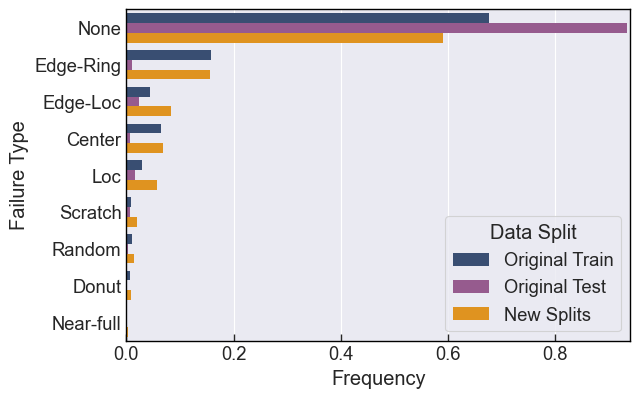

In [200]:
sns.set_style(
    "darkgrid",
    {
        "xtick.direction": "in",
        "ytick.direction": "in",
        # "xtick.top": True,
        # "ytick.right": True,
        "xtick.bottom": True,
        # "ytick.left": True,
        "axes.linewidth": "2.4",
        "axes.edgecolor": "black",
        # "axes.labelcolor": "black",
    },
)
sns.set_context("paper", font_scale=1.5)

fig, ax = plt.subplots(figsize=(6.5, 4.3))
sns.barplot(x="Frequency", y="failureType", hue="Data Split", data=df_melt, order=new_counts.index, palette=["#2f4b7c", "#a05195", "#ff9900"], linewidth=0, ax=ax)
# sns.barplot(x="Frequency", y="failureType", hue="Data Split", data=df_melt, order=new_counts.index, palette="sfae", linewidth=0, ax=ax)
ax.set_ylabel("Failure Type")
ax.set_xlim(0, 0.94)
plt.savefig("../reports/figures/failure_type_counts.png", dpi=300, bbox_inches="tight")
plt.show()

## Methods

In [225]:
sns.set_theme(style="white")

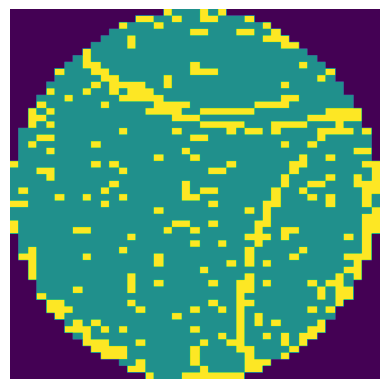

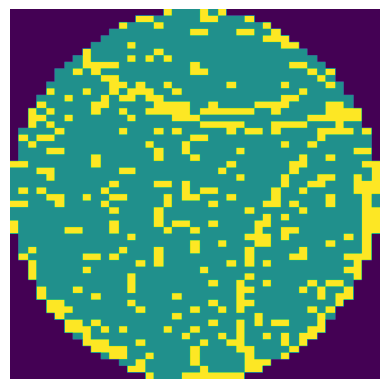

In [266]:
from ssl_wafermap.utilities.transforms import DieNoise, DPWTransform, get_base_transforms, get_inference_transforms
import torch
import torchvision.transforms as T


img = Image.open("../reports/figures/Scratch_9422.png")
img = torch.tensor(np.array(img))

inf_transform = T.Compose(
    [
        T.ToPILImage(),
        T.Resize((224, 224), interpolation=Image.NEAREST),
        T.ToTensor(),
    ]
)

transform = T.Compose(
    [
        DieNoise(0.05),
        T.ToPILImage(),
        T.Resize((224, 224), interpolation=Image.NEAREST),
        T.ToTensor(),
    ]
)


plt.imshow(inf_transform(img).permute(1, 2, 0), cmap="viridis")
plt.axis("off")
plt.savefig("../reports/figures/before_dienoise.png", dpi=300, bbox_inches="tight")
plt.show()

plt.imshow(transform(img).permute(1, 2, 0), cmap="viridis")
plt.axis("off")
plt.savefig("../reports/figures/after_dienoise.png", dpi=300, bbox_inches="tight")
plt.show()